In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [17]:
# Set the data directory
data_dir = "./"

In [ ]:
train_df = pd.read_csv(f'{data_dir}/nexar-collision-prediction/train.csv')
print("Train CSV - First 5 Rows:")
print(train_df.head())

Train CSV - First 5 Rows:
     id  time_of_event  time_of_alert  target
0  1924            NaN            NaN       0
1   822           19.5         18.633       1
2  1429            NaN            NaN       0
3   208           19.8         19.233       1
4  1904            NaN            NaN       0


In [6]:
print("\nTrain CSV Info:")
train_df.info()


Train CSV Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1500 non-null   int64  
 1   time_of_event  750 non-null    float64
 2   time_of_alert  750 non-null    float64
 3   target         1500 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 47.0 KB


In [7]:
print("Train CSV - Summary Statistics:")
print(train_df.describe())

Train CSV - Summary Statistics:
                id  time_of_event  time_of_alert       target
count  1500.000000     750.000000     750.000000  1500.000000
mean   1055.343333      19.101628      17.501271     0.500000
std     620.697385       3.565120       3.658975     0.500167
min       0.000000       3.032000       1.966000     0.000000
25%     520.750000      19.133000      17.290000     0.000000
50%    1039.500000      19.802000      18.259000     0.500000
75%    1593.750000      20.333000      18.977500     1.000000
max    2139.000000      56.800000      55.467000     1.000000


In [8]:
print("\nMissing Values in Train CSV:")
print(train_df.isnull().sum())


Missing Values in Train CSV:
id                 0
time_of_event    750
time_of_alert    750
target             0
dtype: int64


/var/folders/47/fccy1vvs0k12_kgs5t0_qn940000gn/T/ipykernel_85565/3750336053.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=train_df, palette="Set2")


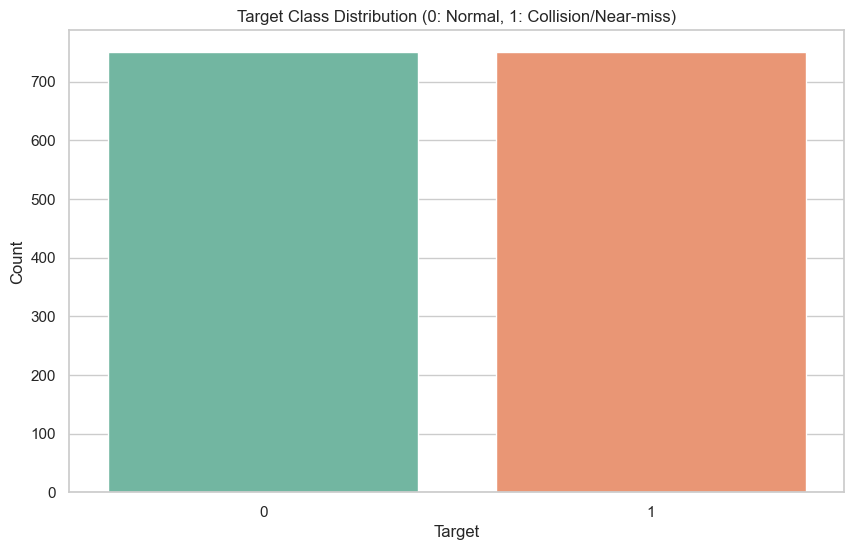

In [9]:
# 1. Distribution of Target Classes
plt.figure()
sns.countplot(x='target', data=train_df, palette="Set2")
plt.title("Target Class Distribution (0: Normal, 1: Collision/Near-miss)")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

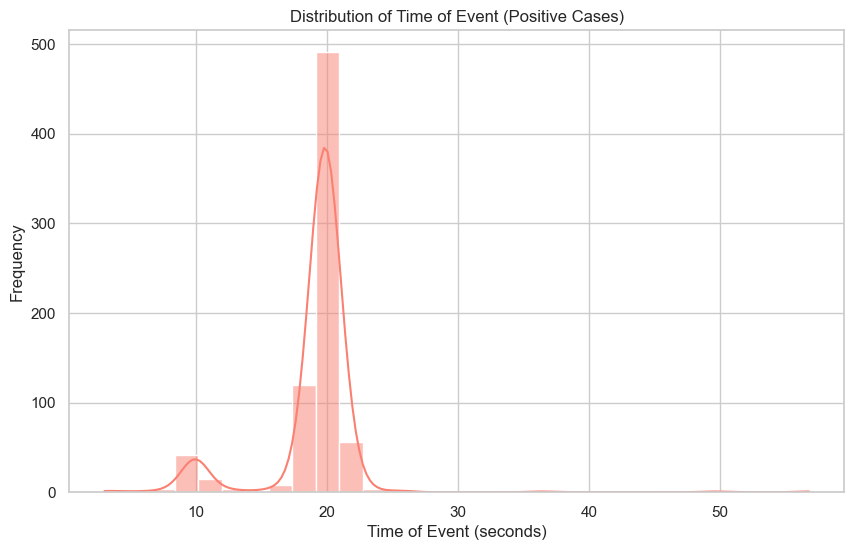

In [10]:
# 2. Distribution of Time of Event (for positive cases)
if 'time_of_event' in train_df.columns:
    plt.figure()
    positive_events = train_df[train_df['target'] == 1]
    sns.histplot(positive_events['time_of_event'].dropna(), bins=30, kde=True, color='salmon')
    plt.title("Distribution of Time of Event (Positive Cases)")
    plt.xlabel("Time of Event (seconds)")
    plt.ylabel("Frequency")
    plt.show()

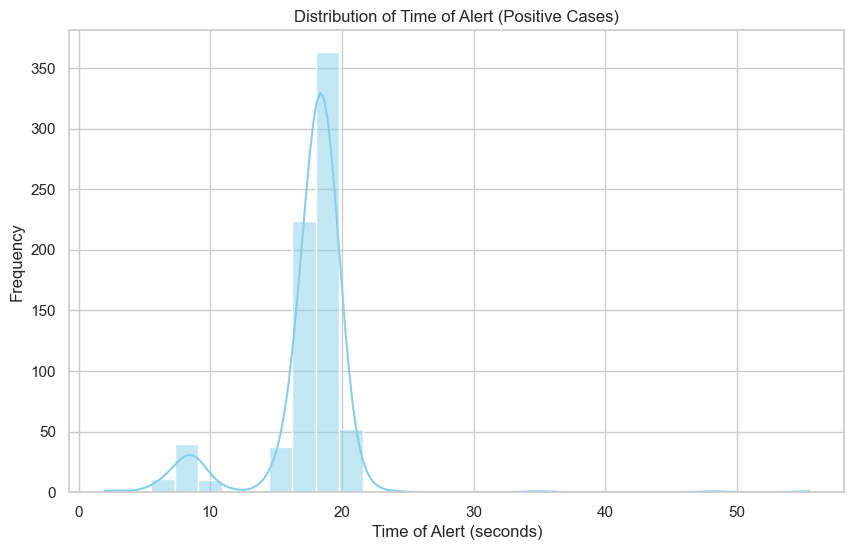

In [11]:
# 3. Distribution of Time of Alert (for positive cases)
if 'time_of_alert' in train_df.columns:
    plt.figure()
    positive_alerts = train_df[train_df['target'] == 1]
    sns.histplot(positive_alerts['time_of_alert'].dropna(), bins=30, kde=True, color='skyblue')
    plt.title("Distribution of Time of Alert (Positive Cases)")
    plt.xlabel("Time of Alert (seconds)")
    plt.ylabel("Frequency")
    plt.show()

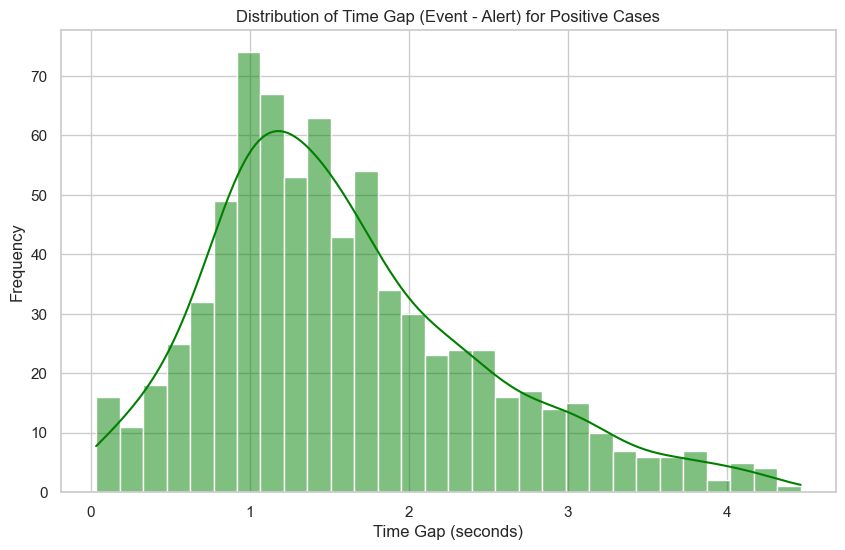

In [12]:
# 4. Distribution of Time Gap between Event and Alert (for positive cases)
if 'time_of_event' in train_df.columns and 'time_of_alert' in train_df.columns:
    train_df['time_gap'] = train_df['time_of_event'] - train_df['time_of_alert']
    plt.figure()
    sns.histplot(train_df.loc[train_df['target'] == 1, 'time_gap'].dropna(), bins=30, kde=True, color='green')
    plt.title("Distribution of Time Gap (Event - Alert) for Positive Cases")
    plt.xlabel("Time Gap (seconds)")
    plt.ylabel("Frequency")
    plt.show()

In [ ]:
test_df = pd.read_csv(f'{data_dir}/nexar-collision-prediction/test.csv')
print("Test CSV - First 5 Rows:")
print(test_df.head())
print("\nTest CSV Shape:", test_df.shape)

Test CSV - First 5 Rows:
    id
0  204
1   30
2  146
3   20
4  511

Test CSV Shape: (1344, 1)


In [15]:
def extract_video_info(video_path):
    """
    Extract basic properties from a video file.
    Returns a dictionary with FPS, frame count, resolution, and duration.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Failed to open video: {video_path}")
        return None
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    duration = frame_count / fps if fps != 0 else 0
    cap.release()
    return {
        "video_path": video_path,
        "fps": fps,
        "frame_count": frame_count,
        "width": width,
        "height": height,
        "duration": duration
    }

def compute_average_brightness(video_path, sample_frames=10):
    """
    Compute an approximate average brightness by sampling a few frames.
    Brightness is calculated as the mean grayscale pixel value.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Failed to open video: {video_path}")
        return None
    brightness_vals = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count == 0:
        cap.release()
        return None
    frames_to_sample = min(sample_frames, frame_count)
    interval = max(1, frame_count // frames_to_sample)
    for i in range(frames_to_sample):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * interval)
        ret, frame = cap.read()
        if ret:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            brightness_vals.append(np.mean(gray))
    cap.release()
    return np.mean(brightness_vals) if brightness_vals else None

In [18]:
video_folder = f'{data_dir}/nexar-collision-prediction/train' 

# List all mp4 files in the specified video folder
video_files = [os.path.join(video_folder, f) for f in os.listdir(video_folder) if f.endswith('.mp4')]

# For quick processing, sample only the first 50 videos (adjust as needed)
sample_video_files = video_files[:50]

video_data = []
for video_file in sample_video_files:
    info = extract_video_info(video_file)
    if info:
        info['avg_brightness'] = compute_average_brightness(video_file, sample_frames=5)
        video_data.append(info)

video_df = pd.DataFrame(video_data)
print("Video EDA Data:")
video_df.head()

Video EDA Data:


,video_path,fps,frame_count,width,height,duration,avg_brightness
0,.//nexar-collision-prediction/train/01811.mp4,30.0,1209,1280,720,40.300000,94.462409
1,.//nexar-collision-prediction/train/01805.mp4,30.0,570,1280,720,19.000000,113.899076
2,.//nexar-collision-prediction/train/01193.mp4,30.0,540,1280,720,18.000000,96.094300
3,.//nexar-collision-prediction/train/01839.mp4,29.1,1174,1280,720,40.343643,35.797421
4,.//nexar-collision-prediction/train/01187.mp4,29.6,1180,1280,720,39.864865,83.800455


In [19]:
video_df.describe()

,fps,frame_count,width,height,duration,avg_brightness
count,50.0000,50.000000,50.0,50.0,50.000000,50.000000
mean,29.9260,1128.560000,1280.0,720.0,37.714291,93.820652
std,0.9587,262.548045,0.0,0.0,8.671827,33.880420
min,23.6000,540.000000,1280.0,720.0,18.000000,9.571037
25%,30.0000,1172.500000,1280.0,720.0,39.286275,74.737723
50%,30.0000,1203.500000,1280.0,720.0,40.150000,103.133090
75%,30.0000,1217.000000,1280.0,720.0,40.339699,116.972296
max,30.6000,1800.000000,1280.0,720.0,60.000000,144.239613


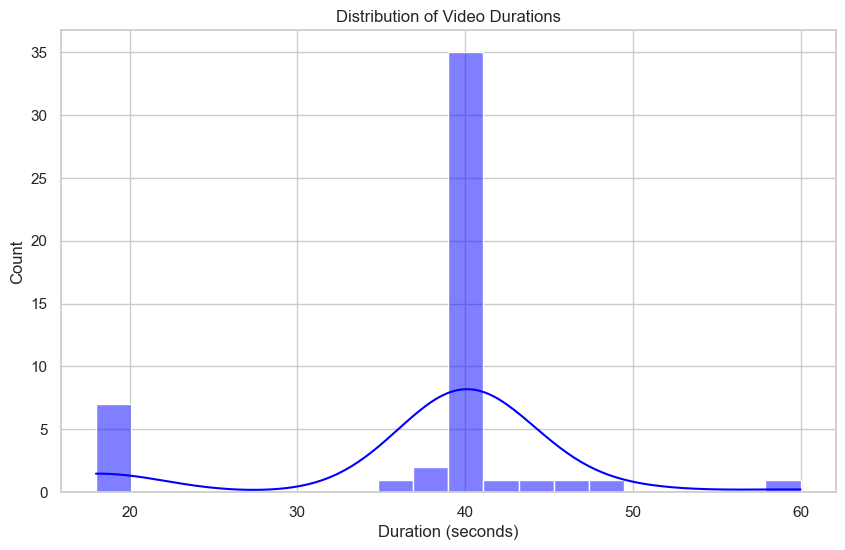

In [20]:
# 1. Video Duration Distribution
plt.figure()
sns.histplot(video_df['duration'], bins=20, kde=True, color='blue')
plt.title("Distribution of Video Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.show()

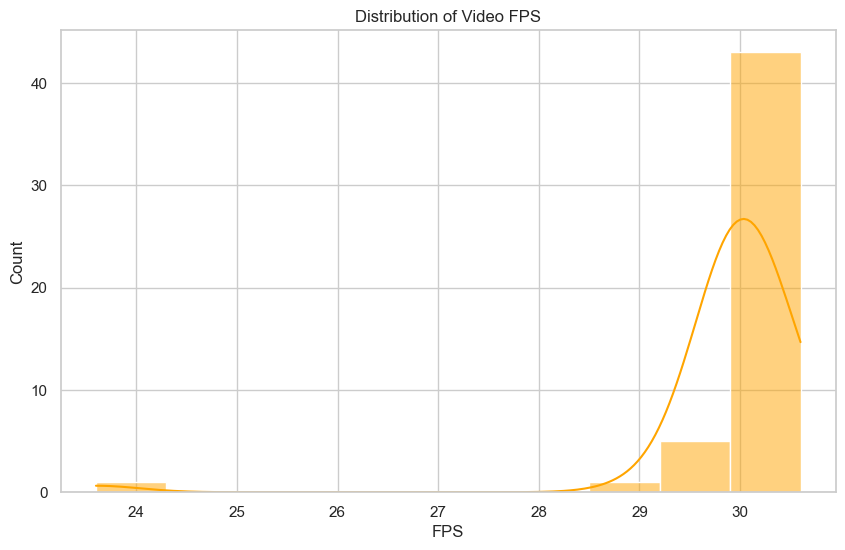

In [21]:
# 2. Video FPS Distribution
plt.figure()
sns.histplot(video_df['fps'], bins=10, kde=True, color='orange')
plt.title("Distribution of Video FPS")
plt.xlabel("FPS")
plt.ylabel("Count")
plt.show()

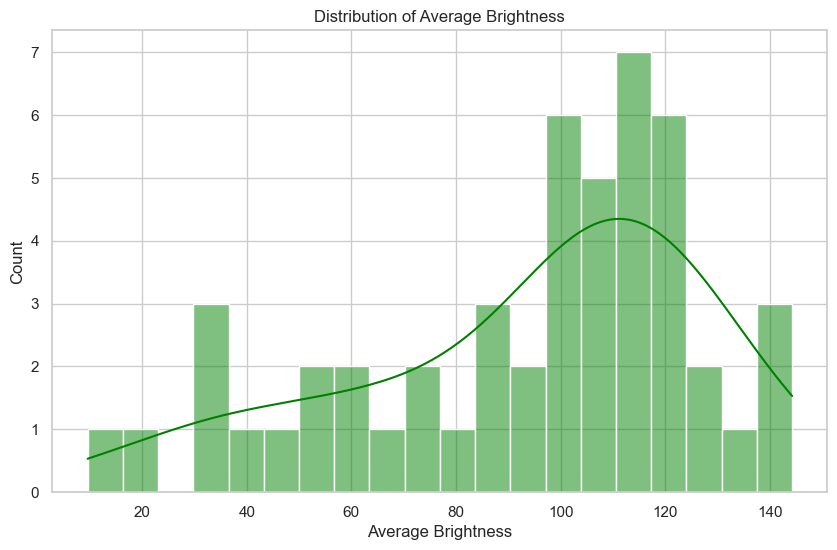

In [22]:
# 3. Average Brightness Distribution
plt.figure()
sns.histplot(video_df['avg_brightness'].dropna(), bins=20, kde=True, color='green')
plt.title("Distribution of Average Brightness")
plt.xlabel("Average Brightness")
plt.ylabel("Count")
plt.show()

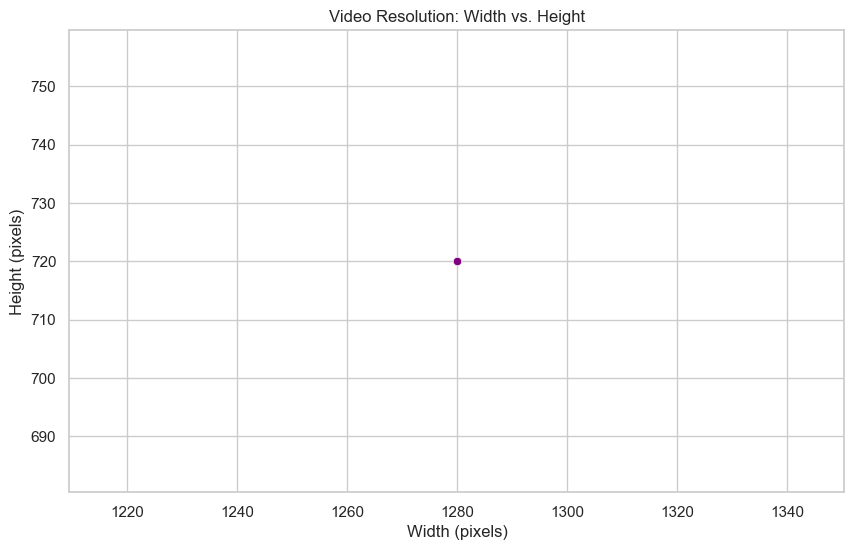

In [23]:
# 4. Video Resolution: Width vs. Height
plt.figure()
sns.scatterplot(x='width', y='height', data=video_df, color='purple')
plt.title("Video Resolution: Width vs. Height")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.show()